### Cab-Driver Agent

In [10]:
# Importing libraries
from collections import deque
import collections
import numpy as np
import random
import pickle
import math
import time

# for building DQN model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

In [11]:
# Import the environment
from Env import CabDriver

In [12]:
# for plotting graphs
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

#### Defining Time Matrix

In [14]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [15]:
# checking the contents of Time_matrix
print("Type: ", type(Time_matrix))
print("Max: ", Time_matrix.max())
print("Min: ", Time_matrix.min())
print("Mean: ", Time_matrix.mean())
print("Var: ", Time_matrix.var())

Type:  <class 'numpy.ndarray'>
Max:  11.0
Min:  0.0
Mean:  3.0542857142857143
Var:  7.93705306122449


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

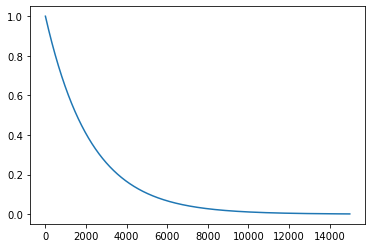

In [16]:
# check for suitable decay rate for mentioned number of episodes
episodes = np.arange(0, 15_000)
epsilon = []
max_epsilon = 1.0
min_epsilon = 0.00001

for i in range(0, 15_000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.00045 * i))
    
plt.plot(episodes, epsilon)
plt.show()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [17]:
# Invoke CabDriver Env class
env = CabDriver()
action_space, state_space, state = env.reset()

In [18]:
class DQNAgent:
    """Deep Q learning Agent class"""

    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1.0
        self.epsilon_max = 1.0
        self.epsilon_decay = -0.00045
        self.epsilon_min = 0.00001
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # tracking state [0, 0, 0] and action (0, 2) at index 2 in the action space
        self.track_state = np.array(env.state_encode_arch1([0, 0, 0])).reshape(1, 36)

        # initializing the state values tracked
        self.states_tracked = []

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """Function to build a neural network"""
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # output layer
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        # model.summary
        return model

    def get_action(self, state, possible_actions_index, actions, episode):
        """Choosing an action for a given state and episode based on epsilon-greedy policy"""
        # calculating decay factor for given episode
        self.epsilon = self.epsilon_min + ((self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * episode))

        if np.random.rand() <= self.epsilon:
            # Exploration: choosing a random action from ride requests
            return random.choice(possible_actions_index)
        else:
            # Exploitation: choose the action with the highest state action value
            # Reshape state to (1, state_size), so that the first index corresponds to the batch size
            encoded_states = np.array(env.state_encode_arch1(state)).reshape(1, self.state_size)

            # predict q values for all possible actions of a given state
            pred_q_values = self.model.predict(encoded_states)

            # Filter/Truncate the array of predicted q values corresponding to selected requests
            # for a given location i.e, to only those actions that are part of the ride requests.
            possible_q_values = [pred_q_values[0][i] for i in possible_actions_index]

            # choosing request with high q value and sending the correspoding action
            return possible_actions_index[np.argmax(possible_q_values)]

    def append_sample(self, state, action, reward, next_state, done):
        """Appending state, action, reward, next_state to replay buffer"""
        self.memory.append((state, action, reward, next_state, done))

        # pick samples randomly from replay memory (with batch_size) and train the network

    def train_model(self):
        """Train the neural network"""
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initializing 2 matrices: update_input and update_output
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            for i in range(self.batch_size):
                state, action, reward, next_state, is_done = mini_batch[i]
                update_input[i] = env.state_encode_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encode_arch1(next_state)
                done.append(is_done)

            # predicting the target q values from state s
            target = self.model.predict(update_input)
            # target for q network
            target_q_val = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                if done[i]:  # if terminal state
                    target[i][actions[i]] = rewards[i]
                else:  # if non terminal state
                    target[i][actions[i]] = rewards[i] + (self.discount_factor * np.max(target_q_val[i]))

            # fitting model and tracking the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save_tracking_states(self):
        # using the model to predict q value of the state we are tracking
        q_value = self.model.predict(self.track_state)
        # grabbing the q value of action index we are tracking
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        # save model weights and model object
        self.model.save("model.h5")
        with open(name, 'wb') as file:
            pickle.dump(self.model.get_weights(), file, pickle.HIGHEST_PROTOCOL)

### DQN block
for episode in range(EPISODES):

    - # Write code here
    - # Call the environment
    - # Call all the initialised variables of the environment
    

    - #Call the DQN agent
    
    
    - while !terminal_state:
        
        -- # Write your code here
        -- # 1. Pick epsilon-greedy action from possible actions for the current state
        -- # 2. Evaluate your reward and next state
        -- # 3. Append the experience to the memory
        -- # 4. Train the model by calling function agent.train_model
        -- # 5. Keep a track of rewards, Q-values, loss

In [19]:
# episodes and other parameters
episode_time = 24 * 30  # 30 days before which car has to be recharged
EPISODES = 15_000
m = 5
t = 24
d = 7

# Set up state and action sizes.
state_size = m + t + d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []

# Rewards for state [0, 0, 0] being tracked.
rewards_init_state = []

##### Run the episodes, build up replay buffer and train the model.
Note:
The moment the total episode time exceeds 720 (30 days), we ignore the most recent ride and do NOT save that experience in the replay memory. <br>
The init state is randomly picked from the state space for each episode.

In [ ]:
# Run the episodes, build up replay buffer and train the model
start_time = time.time()
score_tracked = []

print("Initiating Episodic Training")
for episode in range(EPISODES):
    terminal_state = False
    score = 0
    track_reward = False

    # recreating new object at each episode i.e, resetting
    env = CabDriver()
    action_space, state_space, state = env.reset()

    # saving the initial state so that reward can be tracked if state is [0, 0, 0]
    initial_state = env.state_init

    total_time = 0
    while not terminal_state:
        # getting a list of ride requests the driver got
        possible_actions_indices, actions = env.get_requests(state)
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state, possible_actions_indices, actions, episode)
        # 2. Evaluate your reward and next state
        reward, next_state, ride_time = env.step(state, env.action_space[action], Time_matrix)

        # total time taken for the ride
        total_time += ride_time

        if total_time > episode_time:
            # if the total time taken crosses the time limit of 720, stop the episode
            terminal_state = True
        else:
            # 3. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)

            if (episode + 1) % 20 == 0:
                # 4. Train the model by calling function agent.train_model
                agent.train_model()

            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # print status for every 100 episodes
    if ((episode + 1) % 100) == 0:
        print(f"Episode: {episode + 1}, Reward: {score}, Memory Length: {len(agent.memory)}" +
              f", Agent Epsilon: {agent.epsilon}, Total Ride Time: {total_time}")

    # saving the q value of the state-action pair we are tracking after every 50
    if (episode + 1) % 50 == 0:
        agent.save_tracking_states()

    # total rewards per episode
    score_tracked.append(score)

    # save model for every 1000 episode
    if (episode + 1) % 1000 == 0 and episode != 0:
        print(f"Saving model at {episode + 1}")
        agent.save(name="model_weights.pkl")

print(f"Total Elapsed Time: {time.time() - start_time}")

### Tracking Convergence
#### Tracking the state-action pairs for checking convergence

In [ ]:
# printing the states converged
print(agent.states_tracked)

#### Plotting Q value convergence for state action pairs

In [ ]:
# q value convergence plot
plt.figure(0, figsize=(16, 7))
plt.title('Q_value for state [0, 0, 0]  action (0, 2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis, np.asarray(agent.states_tracked))
plt.show()

Using Log scale to view convergence as the values vary drastically in the beginning until it converges and becomes stable.
#### Tracking Rewards per Episode

In [ ]:
# tracking rewards gained for every 4th episode.
sample_score_tracked = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

In [ ]:
# plot to view rewards obtained per episode
plt.figure(0, figsize=(16, 7))
plt.title('Rewards Obtained per Episode')
xaxis = np.asarray(range(0, len(sample_score_tracked)))
plt.plot(xaxis, np.asarray(sample_score_tracked))
plt.show()